# Improving Performances

Now that we have seen some tricks to improve performances of a CNN, let's apply them to the CIFAR10 dataset that we used in our previous exercise. 

To keep things simple, we will optimize two hyperparameters.

For our data augmentation, we are going to use the `RandAugment` [auto-augmentation policy](https://pytorch.org/vision/main/generated/torchvision.transforms.RandAugment.html) which only takes one parameter, called `magnitude`. This parameter will be one of the parameters we will optimize in our hyperparameter search.

We will also optimize the learning rate for the gradient descent. 

When doing hyperparameter optimization, it is important to have high-level functions (or scripts) that receive our hyperparameters as inputs, so we can run as many training runs as we need by only varying the calling to the function (or the script). Of course, this would not work if we were to hard-code the parameters.

Ok, enough with the introduction, let's get started!

As usual, let's start by installing our requirements:

In [4]:
# !pip install -U -q -r requirements.txt

Let's also make sure that the GPU is active (otherwise things will be _very_ slow):

In [5]:
import torch
import numpy as np
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

# torch.manual_seed(42)

# check if CUDA is available
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...


---
## Data Augmentation

Here we write two functions that create appropriate transforms for the training, validation and test datasets, and then create the relative dataloaders.

As usual, complete the code in the sections marked with `# YOUR CODE HERE`.

In [6]:
import torchvision.transforms as T
from torchvision import datasets
from torch.utils.data.sampler import SubsetRandomSampler
import random
import multiprocessing
from helpers import get_train_val_data_loaders, get_test_data_loader
import torch.multiprocessing
torch.multiprocessing.set_sharing_strategy('file_system')

# Let's write a function that gives us the transforms so we can optimize the hyperparameters
def get_transforms(rand_augment_magnitude):

    # These are the per-channel mean and std of CIFAR-10 over the dataset
    mean = (0.49139968, 0.48215827, 0.44653124)
    std = (0.24703233, 0.24348505, 0.26158768)

    # Define our transformations
    return {
        "train": T.Compose(
            [
                # All images in CIFAR-10 are 32x32. We enlarge them a bit so we can then
                # take a random crop
                T.Resize(40),
                
                # take a random part of the image
                T.RandomCrop(32),
                
                # Horizontal flip is not part of RandAugment according to the RandAugment
                # paper
                T.RandomHorizontalFlip(0.5),
                
                # Use RandAugment
                # RandAugment has 2 main parameters: how many transformations should be
                # applied to each image, and the strength of these transformations. This
                # latter parameter should be tuned through experiments: the higher the more
                # the regularization effect.
                # Setup a T.RandAugment transformation using 2 as num_opts, and the
                # rand_augment_magnitude input parameter as magnitude. 
                # Use T.InterpolationMode.BILINEAR as interpolation. Look at the pytorch
                # manual if needed: 
                # https://pytorch.org/vision/main/generated/torchvision.transforms.RandAugment.html
                
                # YOUR CODE HERE
                T.RandAugment(num_ops = 2, magnitude=rand_augment_magnitude),
                
                T.ToTensor(),
                T.Normalize(mean, std),
            ]
        ),
        "valid": T.Compose(
            [
                # Both of these are useless, but we keep them because
                # in a non-academic dataset you will need them
                T.Resize(32),
                T.CenterCrop(32),
                
                # Convert to tensor and apply normalization:
                # YOUR CODE HERE
                T.ToTensor(),
                T.Normalize(mean, std),
            ]
        ),
        # Identical to the valid set in this case
        "test": T.Compose(
            [
                T.Resize(32),
                T.CenterCrop(32),
                
                # Convert to tensor and apply normalization:
                
                # YOUR CODE HERE
                T.ToTensor(),
                T.Normalize(mean, std),
            ]
        ),
    }


def get_data_loaders(batch_size, valid_size, transforms, num_workers, random_seed=42):
    
    # Reseed random number generators to get a deterministic split. This is useful
    # when comparing experiments, so you'll know they all run on the same data.
    # In principle you should repeat this a few times (cross validation) to see
    # the variability of your measurements, but we won't do this here for simplicity
    torch.manual_seed(random_seed)
    random.seed(random_seed)
    np.random.seed(random_seed)
    
    # Get the CIFAR10 training dataset from torchvision.datasets and set the transforms
    # We will split this further into train and validation in this function
    train_data = datasets.CIFAR10("../data", train=True, download=True, transform=transforms['train'])
    valid_data = datasets.CIFAR10("../data", train=True, download=True, transform=transforms['valid'])

    # Compute how many items we will reserve for the validation set
    n_tot = len(train_data)
    split = int(np.floor(valid_size * n_tot))

    # compute the indices for the training set and for the validation set
    shuffled_indices = torch.randperm(n_tot)
    train_idx, valid_idx = shuffled_indices[split:], shuffled_indices[:split]

    # define samplers for obtaining training and validation batches
    train_sampler = SubsetRandomSampler(train_idx)
    valid_sampler = SubsetRandomSampler(valid_idx)

    # prepare data loaders (combine dataset and sampler)
    # NOTE that here we use train_data for the train dataloader but valid_data
    # for the valid_loader, so the respective transforms are applied
    train_loader = torch.utils.data.DataLoader(
        train_data, batch_size=batch_size, sampler=train_sampler, num_workers=num_workers
    )
    valid_loader = torch.utils.data.DataLoader(
        valid_data, batch_size=batch_size, sampler=valid_sampler, num_workers=num_workers
    )
    
    test_data = datasets.CIFAR10("../data", train=False, download=True, transform=transforms['test'])
    test_loader = torch.utils.data.DataLoader(
        test_data, batch_size=batch_size, num_workers=num_workers
    )
    
    return {'train': train_loader, 'valid': valid_loader, 'test': test_loader}

# specify the image classes
classes = [
    "airplane",
    "automobile",
    "bird",
    "cat",
    "deer",
    "dog",
    "frog",
    "horse",
    "ship",
    "truck",
]

# Model Definition

Here we use a model very similar to the one we used before, but we add Batch Normalization that makes our training faster and more robust, and also allows us to go deeper.

In [7]:
import torch.nn as nn
import torch.nn.functional as F

# define the CNN architecture
class Net(nn.Module):
    def __init__(self, n_classes=10):
        
        super().__init__()
        # conv layers
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(64, 128, kernel_size=3, padding=1)

        # pooling to reduce the features
        self.pool = nn.MaxPool2d(2,2)
        
        # drop to prevent overfitting
        self.drop2d = nn.Dropout2d(p=0.2)
        self.drop = nn.Dropout(p=0.5)

        # batchnorm to train the network faster and get more accurate network
        self.batch2dN16 = nn.BatchNorm2d(16)
        self.batch2dN32 = nn.BatchNorm2d(32)
        self.batch2dN64 = nn.BatchNorm2d(64)
        self.batch2dN128 = nn.BatchNorm2d(128)
        
        # fully connected layers
        self.fc1 = nn.Linear(128*2*2, 256)
        self.fc2 = nn.Linear(256, 64)
        self.fc3 = nn.Linear(64, n_classes)
        # batchnorm for fully connected layers
        self.batch1dN256 = nn.BatchNorm1d(256)
        self.batch1dN64 = nn.BatchNorm1d(64)

    def forward(self, x):
        x = F.relu(self.pool(self.batch2dN16(self.conv1(x)))) # -> 16x16x16
        x = self.drop2d(x)

        x = F.relu(self.pool(self.batch2dN32(self.conv2(x)))) # -> 32x8x8
        x = self.drop2d(x)

        x = F.relu(self.pool(self.batch2dN64(self.conv3(x)))) # -> 64x4x4
        x = self.drop2d(x)

        x = F.relu(self.pool(self.batch2dN128(self.conv4(x)))) # -> 128x2x2
        x = self.drop2d(x)

        x = torch.flatten(x, 1) # flatten all dimensions except batch
        # nn.Flatten(),  # -> 1x128x2x2

        x = F.relu(self.batch1dN256(self.fc1(x)))
        x = self.drop(x)
        x = F.relu(self.batch1dN64(self.fc2(x)))
        x = self.fc3(x)
        return x


# create a complete CNN
model = Net()

# move tensors to GPU if CUDA is available
if train_on_gpu:
    model.cuda()


---
# Learning Rate Finder

Before we start our training, let's find a range for the learning rate that makes sense for our situation. We will use the learning rate finder that we've seen in one of the previous videos:

In [11]:
# Feel free to look into the code of lr_finder and see how it works!
from lr_finder import lr_finder
import matplotlib.pyplot as plt

batch_size = 64
valid_size = 0.2
num_workers = multiprocessing.cpu_count()

transforms = get_transforms(rand_augment_magnitude=9)
data_loaders = get_data_loaders(batch_size, valid_size, transforms, num_workers)

# Range  and number of steps for the learning rate
min_lr = 1e-5
max_lr = 1
n_steps = min(len(data_loaders['train']), 200)

# specify loss function (categorical cross-entropy)
loss = nn.CrossEntropyLoss()

losses = lr_finder(min_lr, max_lr, n_steps, loss, model, data_loaders)

# Plot the results
plt.plot(losses.keys(), losses.values())
plt.xscale("log")
plt.ylabel("loss")
plt.xlabel("learning rate (log scale)")

# Adjust the range on the y-axis to see things more clearly
plt.xlim([1e-4, None])
plt.ylim([min(losses.values()), np.percentile(list(losses.values()), 97)])

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


Remember that a good initial choice for the learning rate is in the middle of the steep part. In this case it seems that 0.04 is a good initial choice.

# Learning Rate Scheduler + Hyperparameter Optimization
Let's also use two other tricks we have just learned: the learning rate scheduler, that changes the learning rate as the training progresses, and the hyperparameter optimization that optimizes the choices to maximize performance.

Let's start by writing an optimize function that leverages the Learning Rate scheduler:

In [6]:
from livelossplot import PlotLosses
from livelossplot.outputs import MatplotlibPlot
from helpers import train_one_epoch, valid_one_epoch
import torch.optim


def optimize(data_loaders, model, optimizer, loss, n_epochs, save_path, interactive_tracking=False):
    
    # This is a plotting function
    def after_subplot(ax: plt.Axes, group_name: str, x_label: str):
        """Add title xlabel and legend to single chart"""
        ax.set_title(group_name)
        ax.set_xlabel(x_label)
        ax.legend(loc="center right")
        
    # initialize tracker for minimum validation loss
    if interactive_tracking:
        liveloss = PlotLosses(outputs=[MatplotlibPlot(after_subplot=after_subplot)])
    else:
        liveloss = None

    valid_loss_min = None
    logs = {}

    # Learning rate scheduler: setup a learning rate scheduler that
    # reduces the learning rate when the validation loss reaches a
    # plateau. Use torch.optim.lr_scheduler.ReduceLROnPlateau, with
    # a treshold of 0.01. Look at the docs if in doubt:
    # https://pytorch.org/docs/stable/generated/torch.optim.lr_scheduler.ReduceLROnPlateau.html
    
    # YOUR CODE HERE
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', threshold=0.01, verbose=True)
    for epoch in range(1, n_epochs + 1):

        train_loss = train_one_epoch(
            data_loaders["train"], model, optimizer, loss
        )

        valid_loss = valid_one_epoch(data_loaders["valid"], model, loss)

        # If the validation loss decreases by more than 1%, save the model
        if valid_loss_min is None or (
                (valid_loss_min - valid_loss) / valid_loss_min > 0.01
        ):

            # Save the weights to save_path
            torch.save(model.state_dict(), save_path)  # -

            valid_loss_min = valid_loss

        # Update learning rate, i.e., make a step in the learning rate scheduler
        # Remember to use the validation loss, so that the learning rate scheduler
        # will change the learning rate when the validation loss is not 
        # decreasing anymore
        
        # YOUR CODE HERE
        scheduler.step(valid_loss)
        
        # Log the losses and the current learning rate
        if interactive_tracking:
            logs["loss"] = train_loss
            logs["val_loss"] = valid_loss
            logs["lr"] = optimizer.param_groups[0]["lr"]

            liveloss.update(logs)
            liveloss.send()

Now let's write a function that trains and validates our model given some hyperparameters. Let's consider for simplicity just two hyperparameters: the learning rate and the strength of the data augmentation in `RandAugment`.

We are also going to track our experiments with `mlflow`.

In [7]:
import mlflow 
from helpers import one_epoch_test

def train_one_model(learning_rate, rand_augment_magnitude, n_epochs):
    
    # TODO: the batch_size, valid_size, and num_workers are better be passed through train_one_model arguement
    transforms = get_transforms(rand_augment_magnitude=rand_augment_magnitude)
    data_loaders = get_data_loaders(batch_size, valid_size, transforms, num_workers)
    model = Net()
    
    if train_on_gpu:
        model.cuda()
    
    optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
    loss = nn.CrossEntropyLoss()
    
    with mlflow.start_run():
        
        optimize(data_loaders, model, optimizer, loss, n_epochs, "best_val_loss.pt", interactive_tracking=True)
        
        # Restore best validation loss
        model.load_state_dict(torch.load('best_val_loss.pt'))
        
        # Test model on *validation* set (never optimize your hyperparameters on the 
        # test set!)
        val_loss, preds, actuals = one_epoch_test(data_loaders['valid'], model, loss)
        
        # Use mlflow.log_param to log the learning rate and the
        # rand_augment_magnitude
        
        # YOUR CODE HERE
        mlflow.log_param("learning_rate", learning_rate)
        mlflow.log_param("rand_augment_magnitude", rand_augment_magnitude)
        
        # Use mlflow.log_metric to log your validation loss
        # YOUR CODE HERE
        mlflow.log_metric("val_loss", val_loss)
        
        val_accuracy = (np.array(preds)==np.array(actuals)).sum() / len(actuals)
        
        # Use mlflow to log the validation accuracy as a metric
        # YOUR CODE HERE
        mlflow.log_metric("val_accuracy", val_accuracy)
        
        # Use mlflow.log_artifact to log the best_val_loss.pt file
        # YOUR CODE HERE
        mlflow.log_artifact('best_val_loss.pt')


## Random Search
Let's use the random search technique to explore our hyperparameters:

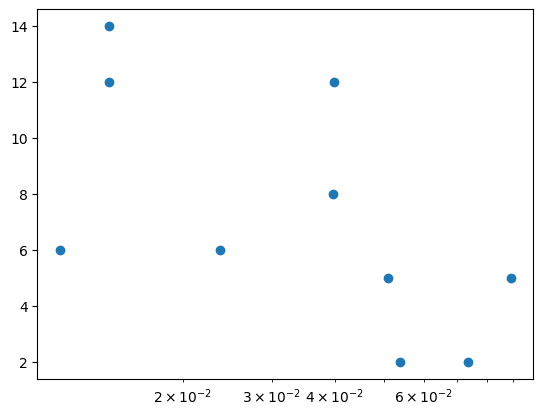

In [8]:
# Make a random grid of learning rate and rand_augment_magnitude

# the following min max selected based on the result of the learning rate finder above.
min_lr = 0.01
max_lr = 0.1

# Here you can decide how many experiments to run
# Run between 5 and 20. The more you run the better
# your results might be, but of course it will take
# longer
# Normally you would use a lot more than that, which is why
# you typically do hyperparam optimization in the cloud so 
# all the experiments can run in parallel
n_grid = 10 # YOUR CODE HERE

# Sample log-uniformly the learning rate
lrs = 10**(np.random.uniform(np.log10(min_lr), np.log10(max_lr), n_grid))
# Sample uniformly the rand augment transform strength
r_a_mag = np.random.randint(1, 15, n_grid)

# Plot our grid
_ = plt.scatter(lrs, r_a_mag)
_ = plt.xscale("log")

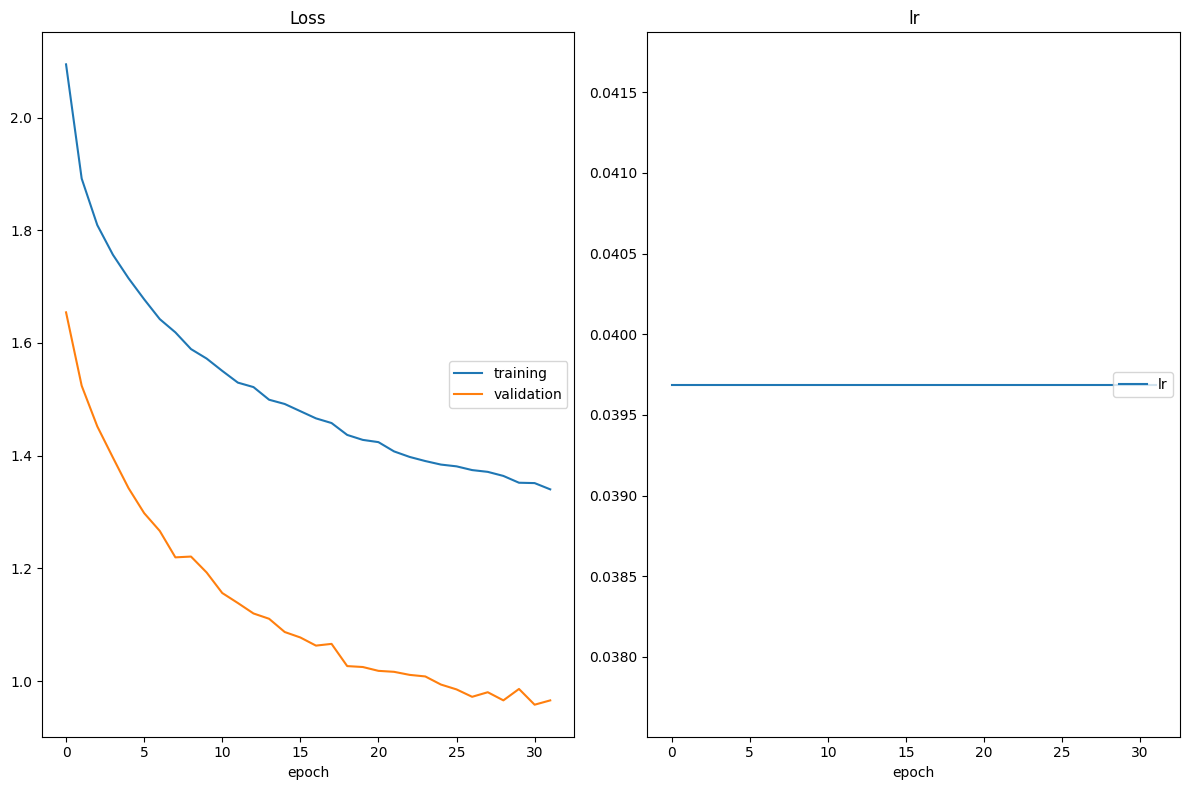

Exception ignored in: <function _releaseLock at 0x7fc1fe5918b0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.8/logging/__init__.py", line 227, in _releaseLock
    def _releaseLock():
KeyboardInterrupt: 


In [9]:
# Run our experiments
for lr, rand_aug_mag in zip(lrs, r_a_mag):
    train_one_model(lr, rand_aug_mag, n_epochs=70)

We can now see the results of our experiments. If you are running locally, you could now run `mlflow ui` to explore the results. If you are in the Udacity workspace, use the following code that reads the results and return them as a pandas DataFrame:

In [1]:
import mlflow

runs = mlflow.search_runs()
sorted_runs = runs[
    [
        "run_id",
        "params.learning_rate",
        "params.rand_augment_magnitude",
        "metrics.val_loss",
        "metrics.val_accuracy",
    ]
].sort_values(by='metrics.val_loss')
sorted_runs

,run_id,params.learning_rate,params.rand_augment_magnitude,metrics.val_loss,metrics.val_accuracy
1,d165cb80d84844619e68d4d95908ba4b,0.05395030966670226,2,0.794085,0.7200
2,04029c76322e405e9bb2e0b053d9f301,0.08927180304353625,5,0.837627,0.7059
3,dcb3f9ad8f804bd193ff330555f1b49a,0.02368863950364078,6,0.865979,0.6986
0,4297acf3383844c6b1876e808aa7b01d,None,None,NaN,NaN
4,969e67dedd1b48c3997be6d49a130a36,None,None,NaN,NaN
5,9f96e7dffd9d4a1b99cf5c4a5e7cf469,None,None,NaN,NaN
6,e06661bd22e243199ea0f26bd16f6903,None,None,NaN,NaN
7,2534692b08a24b0fac782b1c8353b02c,None,None,NaN,NaN
8,92663b50eaba46d1820efc81cfc74d9d,None,None,NaN,NaN
9,60af64ed86bb45198cd1038ea7f8214f,None,None,NaN,NaN


In [2]:
from mlflow.tracking import MlflowClient

# Get the id with the lowest val_loss
lowest_loss_id = sorted_runs.iloc[0]['run_id']

# Fetch the best model from that run
client = MlflowClient()
local_path = client.download_artifacts(lowest_loss_id, "best_val_loss.pt", '.')

###  Load the Model with the Lowest Validation Loss

In [8]:
model.load_state_dict(torch.load('best_val_loss.pt'))

<All keys matched successfully>

---
## Test the Trained Network

Test your trained model on previously unseen data! A "good" result will be a CNN that gets around 70% (or more, try your best!) accuracy on these test images.

In [9]:
from helpers import one_epoch_test

In [12]:
# Test Accuracy: 77% (7701/10000)

test_loss, preds, actuals = one_epoch_test(data_loaders['test'], model, loss)

Testing: 100%|████████████████████████████████| 157/157 [00:08<00:00, 17.53it/s]

Test Loss: 0.816182


Test Accuracy: 71% (7143/10000)


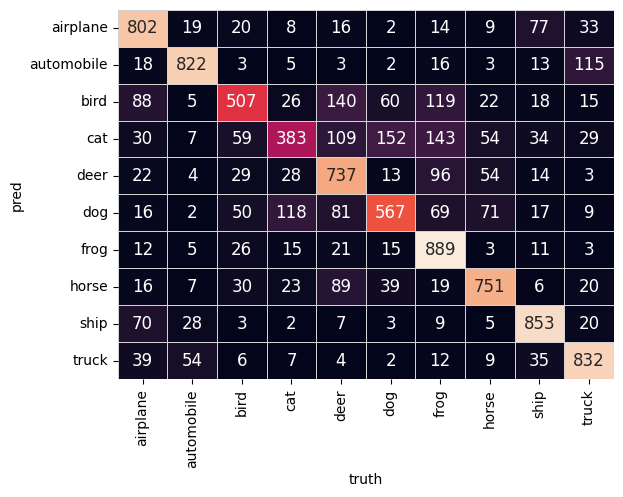

In [13]:
from helpers import plot_confusion_matrix

cm = plot_confusion_matrix(preds, actuals, classes)

We have improved on our previous results by almost 5%. There is a lot more that can be done, feel free to keep experimenting with different augmentations for example.